# Use this notebook to diagonalise 3D Hamiltonian

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Math, display
import numpy as np
import sympy as sp
from scipy import constants as const
from scipy import sparse

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from twod_trap import DoubleTweezer

## Trap parameters:

In [2]:
initial_power = 100* si.uW
initial_waist = 1.1*si.uW
initial_distance = 1.27*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

In [3]:
omega_z1 = sp.sqrt(4*trap.power_tweezer1*trap.a/sp.pi**3/trap.m) * trap.wvl/trap.waist_tweezer1**3
omega_z2 = sp.sqrt(4*trap.power_tweezer2*trap.a/sp.pi**3/trap.m) * trap.wvl/trap.waist_tweezer2**3

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer2**2

aspect_ratio1 = omega_r1 / omega_z1
_aspect_ratio1_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio1_latex} \\approx {trap.subs(aspect_ratio1).evalf():.2f}"))

aspect_ratio2 = omega_r2 / omega_z2
_aspect_ratio2_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio2_latex} \\approx {trap.subs(aspect_ratio2).evalf():.2f}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

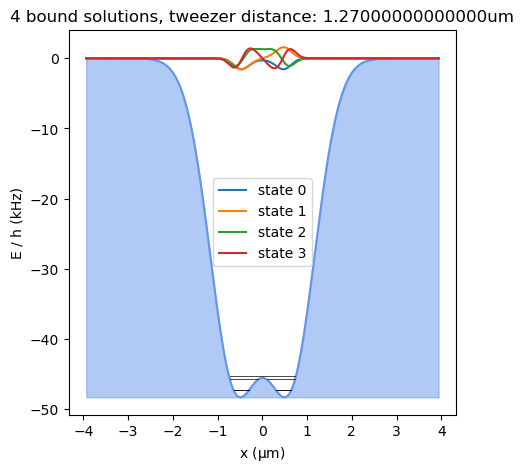

In [4]:
left_cutoff = -0.5*float(trap.subs(trap.distance_tweezers))-3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*float(trap.subs(trap.distance_tweezers))+3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])


# Solve the hamiltonian numerically in axial direction
energies, states, potential, coords = trap.nstationary_solution(
    trap.x, (left_cutoff, right_cutoff), 500, k=4
)

# States that are below the potential barrier
bound_states = energies < potential(left_cutoff)


z_np = np.linspace(left_cutoff, right_cutoff, num=500)
ax: plt.Axes
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(z_np / si.um, potential(z_np) / const.h / si.kHz,color="cornflowerblue" ,marker="None")
ax.set_title(f"{np.sum(bound_states)} bound solutions, tweezer distance: {trap.subs(trap.distance_tweezers)/si.um}um")
ax.set_xlabel(r"x ($\mathrm{\mu m}$)")
ax.set_ylabel(r"E / h (kHz)")
abs_min = np.min(potential(z_np))
ax.fill_between(
    z_np / si.um,
    potential(z_np) / const.h / si.kHz,
    abs_min / const.h / si.kHz,
    alpha=0.5,
    color="cornflowerblue"
)

count = 0
for i, bound in enumerate(bound_states):
    if not bound:
        continue
    energy = energies[i]
    state = states[i]
    ax.plot(
        z_np / si.um,
        np.where(
            (energy > potential(z_np)),
            energy / const.h / si.kHz,
            np.nan,
        ),
        c="k",
        lw=0.5,
        marker="None",
    )
    ax.plot(z_np/si.um, state *1e1, marker="None",label=f"state {count}")#, c="k")
    count += 1

plt.legend()
plt.show()

## Diagonalisation parameters

In [5]:
n_grid_1D = 100

n_pot_steps = [n_grid_1D,n_grid_1D,n_grid_1D]
n_levels = 8

left_cutoff = -0.5*initial_distance-2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
back_cutoff = -2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
front_cutoff = 2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
bottom_cutoff = -1*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])
top_cutoff = 1*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])

extend = [(left_cutoff,right_cutoff),
          (back_cutoff,front_cutoff),
          (bottom_cutoff,top_cutoff)]


# Solve the hamiltonian numerically
energies, states, potential, coords = trap.nstationary_solution(
        [trap.x,trap.y,trap.z], extend, n_pot_steps, k=n_levels,
        method="matrix_free", export=True)


x = coords[trap.x]
y = coords[trap.y]
z = coords[trap.z]
x3D,y3D,z3D = np.meshgrid(coords[trap.x],coords[trap.y],coords[trap.z],indexing="ij")
pot = potential(x3D,y3D,z3D)


files saved with ...._2025-03-21_16-20-09


## Visualise results

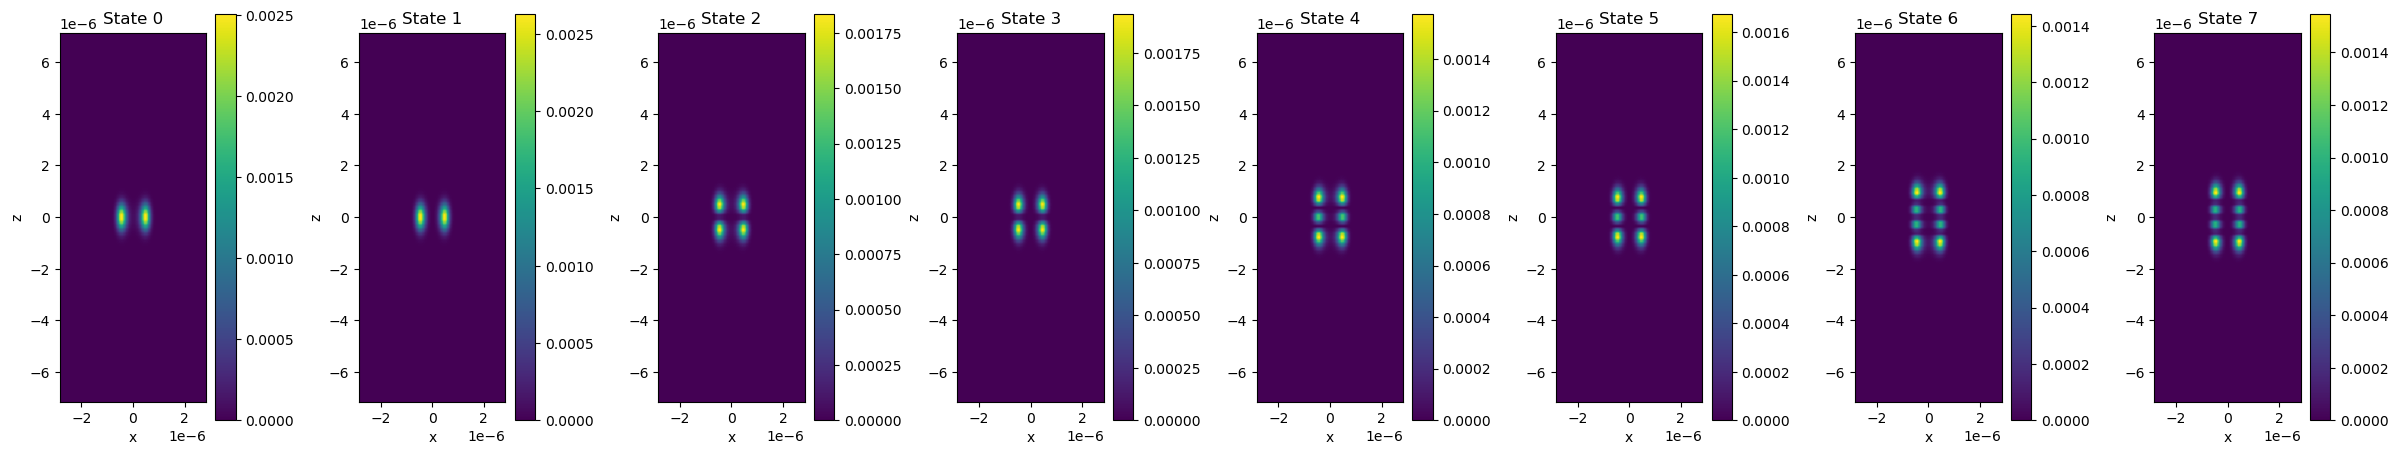

In [6]:
n_states = 8

# Create a 1xn_states grid of subplots (1 row, n_states columns)
fig, axes = plt.subplots(1, n_states, figsize=(18/6*n_states, 5))  # Adjust the size as needed

# Loop over the state numbers from 0 to 5
for state_number, ax in zip(range(n_states), axes):
    # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
    im = ax.imshow(np.abs(states[state_number, :, int(len(y)/2), :].T)**2, extent=[*extend[0], *extend[2]], origin="lower",
                   vmin=np.min(np.abs(states[state_number])**2), vmax=np.max(np.abs(states[state_number])**2))

    # Set labels for each subplot
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_title(f"State {state_number}")
    fig.colorbar(im, ax=ax)  

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
